In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import string
import time
import re
from string import punctuation
import sys

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder , StandardScaler , MaxAbsScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
import itertools

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras import metrics

from keras.models import load_model
import joblib

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def timing(f):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap



def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=3000,neurons=20,
                 n_classes = 8 ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['sparse_categorical_crossentropy'])
    return model


class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    



#Need OPT
def spacy_preprocessing(text_format):
        
    def combine_text(list_of_text):
            combined_text = ' '.join(list_of_text)
            return combined_text
        
    doc  = nlp(text_format)
    tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
    filter_token_sw = [token.lemma_ for token in tokens_list if str.lower(str.strip(token.lemma_)) not in stopwords.words('english')]
   
    return combine_text(filter_token_sw)

vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)


prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])


from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

wc = WordCloud()

# Data Acquisition

In [77]:
#______________________________________________________ DATA INGESTION___________________________________________________________________
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)



#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

label_encoder = LabelEncoder()  
# Encode labels in column 
df['target']= label_encoder.fit_transform(df['label'])

df = df.sample(frac = 1)
# dependent and independent variable
X = df['text']
y = df['target']

df['label'].value_counts()
#_____________________________________________________________________________________________________________________________________________

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

In [78]:
df = df.dropna()

# Exploratory Data Analysis

In [90]:
print(df.shape)
df.head()

(10834, 3)


,text,label,target
1836,Whatever equipment will work on a mac plus or ...,computer,1
2610,\nAm I supposed to take that as a compliment o...,sport,7
3988,\n: >Compiled from the last five Defensive Ave...,sport,7
2289,\nWe also cannot fail to note the intense suff...,religion,4
1312,I agree. It was great for the ESPN people to s...,sport,7


In [91]:
df['label'].value_counts()

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

### Sample for EDA

In [92]:
df_s = df.sample(5000)
df_s['spacy_obj'] = df_s['text'].apply(lambda x:nlp(x))
df_s['label'].value_counts()

computer      1390
science        817
politics       690
automobile     567
sport          556
religion       452
sales          266
medicine       262
Name: label, dtype: int64

In [93]:
sample = df_s.sample(1)
sample

,text,label,target,spacy_obj
1207,I just got off the phone with Mathsoft technic...,computer,1,"(I, just, got, off, the, phone, with, Mathsoft..."


In [94]:
print(sample.text.values[0] ,sample.label)

I just got off the phone with Mathsoft technical service. They
are now admitting a problem of unknown nature with Maple and
Norton Desktop for Windows. They have no clue at this time
and are collecting configuration information on the systems
which exhibit the problem. Anyone having problems loading the
Maple solver in MathCad 4.0 under NDW shoud call technical
support at 617-577-1017. They made no schedule promices,
but are actively working on the problem.

In the meantime, the workaround is to provide a configuration
selection in autoexec.bat to use PROGMAN (yuk, pew) whenever
you plan to use the Maple solver and NDW otherwise. I am using
Norton BE to place a little menu on the screen with a 5 second
timeout to auto boot NDW. 1207    computer
Name: label, dtype: object


In [95]:
sample

,text,label,target,spacy_obj
1207,I just got off the phone with Mathsoft technic...,computer,1,"(I, just, got, off, the, phone, with, Mathsoft..."


In [96]:
len([token.text for token in nlp(sample.text.values[0]) if token.is_alpha ])

122

In [97]:
len(set([token.text for token in nlp(sample.text.values[0]) if token.is_alpha ]))

82

## Example of Preprocessing

In [98]:
df_s.head()

,text,label,target,spacy_obj
1933,\n\n\nI am one of those middle-of-the-road GW2...,computer,1,"(\n\n\n, I, am, one, of, those, middle, -, of,..."
10566,\n1) So what?\n\n2) It will be interesting to ...,politics,3,"(\n, 1, ), So, what, ?, \n\n, 2, ), It, will, ..."
10835,We have a Gateway 486DX50 with a SMC Elite16 S...,computer,1,"(We, have, a, Gateway, 486DX50, with, a, SMC, ..."
10604,"\n\n\nGarrett, you are a really pathetic liar....",politics,3,"(\n\n\n, Garrett, ,, you, are, a, really, path..."
3761,\n[On the issue of 'burning' nuclear wastes us...,science,6,"(\n, [, On, the, issue, of, ', burning, ', nuc..."


In [ ]:
tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
filter_token_sw = [token.lemma_ for token in tokens_list if str.lower(str.strip(token.lemma_)) not in stopwords.words('english')]
   

In [99]:
# df_s['tokens'] =
df_s['tokens'] = df_s['spacy_obj'].apply(lambda x:list(x)  )

In [147]:
df_s['is_alpha_pure'] = df_s['tokens'].apply(lambda x: [token.text for token in x if  token.is_alpha ] )
df_s['is_alpha_num'] = df_s['tokens'].apply(lambda x: [token.text for token in x if  not token.is_alpha ] )
df_s['len_text'] = df_s['text'].apply(lambda x: len(x) )
df_s['unique_text'] = df_s['is_alpha_pure'].apply(lambda x: list(set(x)) ) 

df_s['unique_text_nostop'] =  df_s['tokens'].apply( lambda x : [token.text for token in x if   ( not token.is_punct and not token.is_space  and  token.is_alpha and str.lower(str.strip(token.lemma_)) not in stopwords.words('english')  ) ] ) 

df_s['n_unique_text'] = df_s['is_alpha_pure'].apply(lambda x:len( set(x) ) )
df_s['richness_text'] = df_s['n_unique_text']/df_s['len_text'] 

<AxesSubplot:>

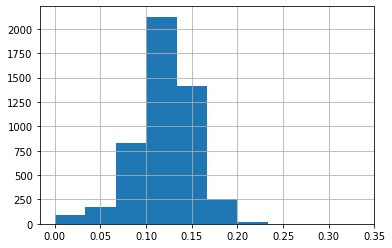

In [145]:
df_s['richness_text'].hist()

In [148]:
from itertools import chain
group_class_docs = df_s.groupby('label')['unique_text_nostop'].apply(list) 
group_class_uniqe_texts = group_class_docs.apply(lambda x : list(itertools.chain(*x)))
group_class_uniqe_texts.apply(lambda x:len(x)) 
grouped_vocabolary = group_class_uniqe_texts.apply(lambda x:str(' '.join(x)))

In [149]:
grouped_vocabolary

label
automobile    certainly possible quite easy cases especially...
computer      one middle road owners satisfied system share ...
medicine      vote create proposed group extension affirmati...
politics      interesting see reaction queers gather Washing...
religion      word released loaded convicted CXOurt children...
sales         WARRIORS TICKETS SALE tickets ca use Last pair...
science       issue burning nuclear wastes using particle be...
sport         general question US readers extensive playoff ...
Name: unique_text_nostop, dtype: object

In [150]:
def word_freq(label): return pd.Series([ t.lemma_ for t in nlp(grouped_vocabolary[label]) if str.lower(str.strip(t.lemma_)) not in stopwords.words('english')  ] ).value_counts()

In [151]:
vocabulary_len_category = dict({ k:len(word_freq(k).index.to_list()) for k in grouped_vocabolary.index.to_list() } )

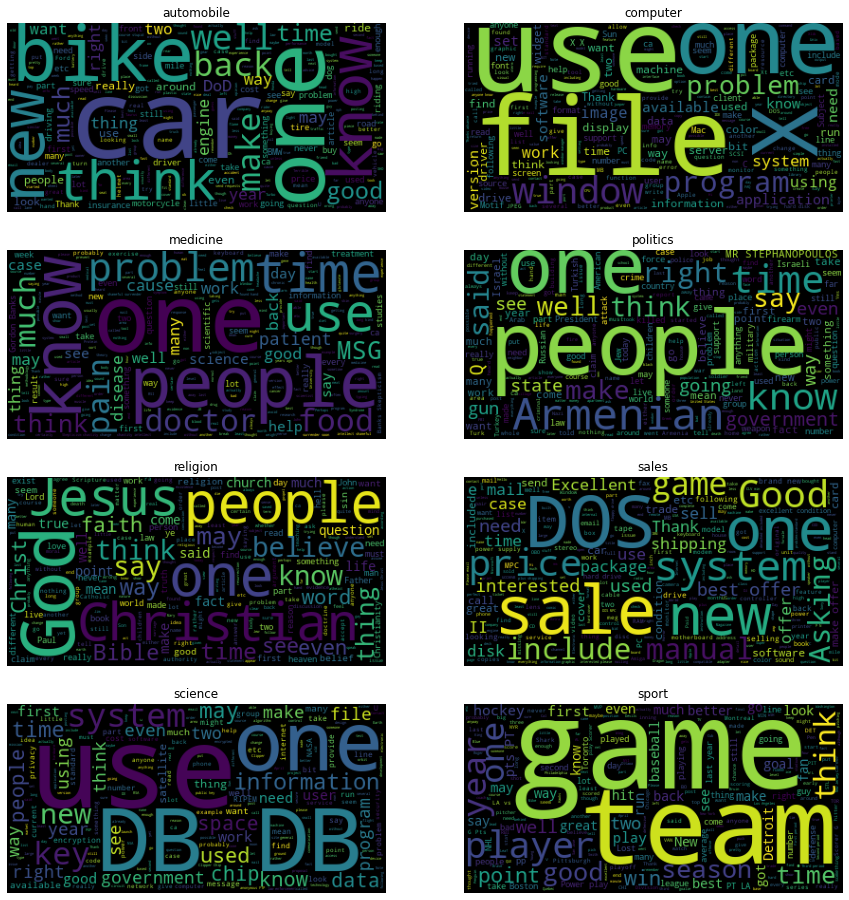

In [152]:
fig = plt.figure(figsize=(15,16))
for n,i in enumerate(grouped_vocabolary.index.to_list()):
    ax = plt.subplot(4,2,n+1)
    wordcloud = WordCloud(max_words=3000).generate(str(grouped_vocabolary[i]))
    ax.set_title(i)
    ax.axis('off')
    ax.imshow(wordcloud)

## We decide the size of sparse matrix tfidf based on the median of the vocabs per category

In [ ]:
pd.Series(vocabulary_len_category).sort_values().describe()#  be aware that the smaple might be biased 

# Preprocessing Pipeline

In [ ]:
# doc  = nlp('I  @  1223 am happy for your new promotion')
# tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
# filter_token_sw = [token.lemma_ for token in tokens_list if token.lower_ not in stopwords.words('english')]
# filter_token_sw

In [ ]:
# Proportions of labels
pd.DataFrame(y.value_counts()).T

### Downsampling Data

In [79]:
def downsample(df):
    minority_frequency  = df['label'].value_counts()[-1]
    minority_label = df['label'].value_counts().index[-1]
    
    df_balanced = df.loc[df['label'] == minority_label , : ].sample(minority_frequency).copy()
    df_balanced = df_balanced.reset_index(drop = True)
    
    label_list = df['label'].value_counts().index.tolist()
    #Sample and concat
    for label in label_list:
        if label != minority_label:
            sample_df = df.loc[df['label'] == label , : ].sample(minority_frequency).copy()
            df_balanced = pd.concat([ df_balanced , sample_df],axis = 0 , ignore_index=True) 
    # Shuffle data
    df_balanced = df_balanced.sample(frac = 1).reset_index(drop = True)
    
    return df_balanced

df_balanced = downsample(df)
# dependent and independent variable
X = df_balanced['text']
y = df_balanced['target']

In [80]:


    
vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)



    

prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])

# DEFINE LABELS IN OHE FORMAT
yc = tf.keras.utils.to_categorical(y,num_classes = 20,dtype=int )

In [81]:
X.shape

(4680,)

# Model Pipeline

### Hyperparameters fine-tuning

In [74]:
# TF IDF DIMENSION will affect the model 
matrix_features  = 3000 # may it be an approximation of the len of vocabolary per each category

n_classes =y.nunique()

#dense_layer_sizes = [[] , []]
#param_grid = dict(neurons=neurons, epochs = epochs, batch_size =batch_size)

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'kc__epochs': [20,30,50],
    'kc__neurons': [10, 20, 30, 100],
    'kc__batch_size':[16, 32,50],
    'kc__dropout': [ 0.3, 0.1, 0]
}


#StratifiedKFold(n_splits=2, shuffle=True)



In [75]:
model_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(use_idf = True,max_features=matrix_features)),
                    ('sparse_to_dense',DenseTransformer()),
                    ('scaler', MaxAbsScaler()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=model_pipeline,
                    verbose=1,
                    cv=skf.split(X_t,y),
                    param_grid=param_grid,
                    scoring='accuracy')

C:\Users\david\AppData\Local\Temp/ipykernel_2356/1337535005.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))


In [76]:
from sklearn import set_config
set_config(display='diagram')

grid

GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001370D0CD660>,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=3000)),
                                       ('sparse_to_dense',
                                        <__main__.DenseTransformer object at 0x00000137F508FBE0>),
                                       ('scaler', MaxAbsScaler()),
                                       ('kc',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x00000137F508FFA0>)]),
             param_grid={'kc__batch_size': [16, 32, 50],
                         'kc__dropout': [0.3, 0.1, 0],
                         'kc__epochs': [20, 30, 50],
                         'kc__neurons': [10, 20, 30, 100],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

#### Grid Search 

In [ ]:
# limit = 100
# X_p = prep_pipeline.fit_transform(X[:limit]).toarray()
# X_p.shape

In [ ]:
# from sklearn.utils.multiclass import type_of_target
# type_of_target(y) , type_of_target(yc)

In [82]:
X_t = prep_pipeline.fit_transform(X)

In [83]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
results.head()

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Tuning Time s: 4590.74


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kc__batch_size,param_kc__dropout,param_kc__epochs,param_kc__neurons,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
146,2.892612,0.029515,0.380000,0.009401,50,0.3,20,20,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.743590,0.772436,0.758333,0.758120,0.011777,1
74,3.350023,0.034255,0.392158,0.019389,32,0.3,20,20,"(1, 1)","{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.738462,0.771795,0.754487,0.754915,0.013612,2
148,3.014429,0.104706,0.374790,0.008012,50,0.3,20,30,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.738462,0.767308,0.753205,0.752991,0.011777,3
169,3.782510,0.124156,0.514090,0.034297,50,0.1,20,10,"(1, 2)","{'kc__batch_size': 50, 'kc__dropout': 0.1, 'kc...",0.740385,0.766026,0.751282,0.752564,0.010507,4
194,2.520893,0.052761,0.356069,0.024609,50,0,20,20,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0, 'kc__...",0.738462,0.762179,0.757051,0.752564,0.010189,4


## Fit the Pipeline

In [84]:
# TEST SAMPLE
# limit = 1000

# model = create_model(neurons=20)
# model.summary()

In [85]:
#+++++++++++++++++++++++ BEST PIPE PARAMS ++++++++++++++++++++++++++++++++
opt_pipeline  = grid_fitted.best_estimator_

t0 = time.time()
fitted_pipe = opt_pipeline.fit(X_t,y)
time.time() - t0 

3.2201156616210938

# Testing Pipeline

In [ ]:
dataset = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)

#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


label_encoder = LabelEncoder()  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])

# drop non in categories
df = df.loc[df['label'].isin(key_categories)]
#++++++++++++++++++++++++ PICK RANDOM 30 % OF TEST++++++++++++++++++++++++++
df = df.sample(frac = 1) 
# dependent and independent variable
X_test = df['text']
y_test = df['target']
#_____________________________________________________________________________________________________________________________________________

In [ ]:
X_test_prep = prep_pipeline.transform(X_test)

In [86]:
y_pred  = opt_pipeline.predict(X_test_prep)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.78      0.65       794
           1       0.88      0.74      0.80      1955
           2       0.65      0.73      0.69       396
           3       0.74      0.70      0.72      1050
           4       0.71      0.77      0.74       649
           5       0.57      0.83      0.68       390
           6       0.69      0.61      0.65      1183
           7       0.90      0.83      0.86       796

    accuracy                           0.73      7213
   macro avg       0.71      0.75      0.72      7213
weighted avg       0.75      0.73      0.74      7213



In [87]:
opt_pipeline

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=3000)),
                ('sparse_to_dense',
                 <__main__.DenseTransformer object at 0x00000137CFF15A60>),
                ('scaler', MaxAbsScaler()),
                ('kc',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001378CEEEFA0>)])

In [ ]:
dist_proba_pred = pd.DataFrame(opt_pipeline.predict_proba(X_test_prep), columns=key_categories)

dist_proba_pred.hist(figsize = (10,8));

In [ ]:
df['label'].unique()

In [71]:
def make_custom_predictions(fitted_pipe):return label_encoder.inverse_transform(fitted_pipe.predict(pd.Series(input('Input-Text:'))))

In [ ]:
make_custom_predictions()

In [ ]:
def save_keras_pipe(pipeline,name_model = 'keras_model.h5', name_pipe ='sklearn_pipeline.pkl' ):
    # Save the Keras model first:
    pipeline.named_steps['kc'].model.save(name_model)

    # This hack allows us to save the sklearn pipeline:
    pipeline.named_steps['kc'].model = None

    # Finally, save the pipeline:
    joblib.dump(pipeline, name_pipe)

In [88]:
save_keras_pipe(fitted_pipe)

# Load the trained model 

In [17]:
dataset = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)

#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


label_encoder = LabelEncoder()  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])

# drop non in categories
df = df.loc[df['label'].isin(key_categories)]
#++++++++++++++++++++++++ PICK RANDOM 30 % OF TEST++++++++++++++++++++++++++
df = df.sample(frac = 1) 
# dependent and independent variable
X_test = df['text']
y_test = df['target']
#_____________________________________________________________________________________________________________________________________________

In [ ]:

# Load the pipeline first:
pipeline = joblib.load('sklearn_pipeline.pkl')

# Then, load the Keras model:
pipeline.named_steps['kc'].model = load_model('keras_model.h5')


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

X_test_prep = prep_pipeline.transform(X_test)
y_pred  = pipeline.predict(X_test_prep)
cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

label_names = df['label'].unique()

print(classification_report(y_test,y_pred, target_names=label_names))
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=False,
                      title='Normalized confusion matrix')

In [ ]:
make_custom_predictions(pipeline)

# Embedding model with Universal Sentence Encoder

In [10]:
# Inserire flag di dominio dummy 

# def spacy_tokenizer(document, nlp=nlp):
#     # tokenize the document with spaCY
#     doc = nlp(document)
#     # Remove stop words and punctuation symbols
#     tokens = [
#         token.text for token in doc if (
#         token.is_stop == False and \
#         token.is_punct == False and \
#         token.text.strip() != '' and \
#         token.text.find("\n") == -1)]
#     return tokens

import tensorflow_hub as hub
# load embeddings model from Tensorflow Hub
#https://stackoverflow.com/questions/62464152/universal-sentence-encoder-load-error-error-savedmodel-file-does-not-exist-at
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


matrix_features  = 512

n_classes =y.nunique()
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=matrix_features,neurons=20,
                 n_classes = n_classes ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['sparse_categorical_crossentropy'])
    return model


In [ ]:
# embed(pd.Series(spacy_preprocessing(X)))

In [12]:
X_t = prep_pipeline.fit_transform(X)

In [13]:
class Embedding(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return embed(X).numpy()
    

emb_pipeline = Pipeline([
                    ('embed', Embedding()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])

#++++++++++++++++++++++++++++++ GRID ++++++++++++++++++++++++++++++++++++++
param_grid = {
    'kc__epochs': [20,30,50],
    'kc__neurons': [10, 20, 30, 100],
    'kc__batch_size':[16, 32,50],
    'kc__dropout': [ 0.3, 0.1, 0]
}

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=emb_pipeline,
                    verbose=1,
                    cv=skf.split(X_t,y),
                    param_grid=param_grid,
                    scoring='accuracy')



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
results.head()



C:\Users\david\AppData\Local\Temp/ipykernel_2356/2802624789.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Tuning Time s: 61142.078


20.289283990859985

In [16]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kc__batch_size,param_kc__dropout,param_kc__epochs,param_kc__neurons,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
74,14.354582,0.288370,5.656976,0.277271,50,0.3,20,30,"{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.792308,0.804487,0.795513,0.797436,0.005155,1
78,13.186686,0.874001,4.861567,0.382476,50,0.3,30,30,"{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.788462,0.807692,0.796154,0.797436,0.007903,1
1,13.765772,0.259575,5.286987,0.783942,16,0.3,20,20,"{'kc__batch_size': 16, 'kc__dropout': 0.3, 'kc...",0.789103,0.801923,0.796795,0.795940,0.005269,3
38,14.323750,0.115464,5.758810,0.835035,32,0.3,20,30,"{'kc__batch_size': 32, 'kc__dropout': 0.3, 'kc...",0.791026,0.797436,0.796795,0.795085,0.002883,4
53,13.806980,0.286871,5.249622,0.552629,32,0.1,30,20,"{'kc__batch_size': 32, 'kc__dropout': 0.1, 'kc...",0.791667,0.796795,0.796154,0.794872,0.002281,5


In [68]:
#+++++++++++++++++++++++ BEST PIPE PARAMS ++++++++++++++++++++++++++++++++
opt_pipeline  = grid_fitted.best_estimator_

t0 = time.time()
fitted_pipe_emb = opt_pipeline.fit(X_t,y)
time.time() - t0 

20.40979266166687

In [18]:
X_test_prep = prep_pipeline.transform(X_test)

In [62]:
y_pred  = fitted_pipe_emb.predict(X_test_prep)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       794
           1       0.90      0.76      0.82      1955
           2       0.70      0.84      0.76       396
           3       0.81      0.76      0.78      1050
           4       0.79      0.79      0.79       649
           5       0.54      0.79      0.64       390
           6       0.62      0.69      0.66      1183
           7       0.88      0.88      0.88       796

    accuracy                           0.77      7213
   macro avg       0.76      0.79      0.77      7213
weighted avg       0.79      0.77      0.78      7213



In [53]:
create_model(init='uniform', features=512, neurons=30, n_classes=8, dropout=0.3).summary()  #batchsize = 50

Model: "sequential_328"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_656 (Dense)           (None, 30)                15390     
                                                                 
 dropout_328 (Dropout)       (None, 30)                0         
                                                                 
 dense_657 (Dense)           (None, 8)                 248       
                                                                 
Total params: 15,638
Trainable params: 15,638
Non-trainable params: 0
_________________________________________________________________


In [69]:
fitted_pipe_emb.named_steps['kc'].model.save('keras_model_emb.h5')

In [89]:
make_custom_predictions(fitted_pipe_emb)

Input-Text: The red team wins the game


array(['sport'], dtype=object)